Starting compression and decompression on sample images...

Image 1 shape: (512, 512)
compress_image: encoded length = 262144 bits


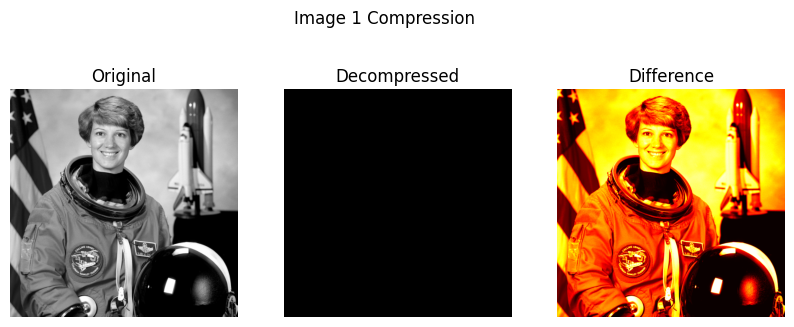

Compression Ratio: 8.00
PSNR: 5.49 dB
Comments:
- DCT + Quantization achieves lossy compression; some details are lost but main structures preserved.
- Huffman coding losslessly compresses quantized coefficients, improving storage efficiency.
- Higher compression ratios reduce image quality (lower PSNR).
- Suitable for images where slight quality loss is acceptable (e.g., photos).

------------------------------------------------------------

Image 2 shape: (512, 512)
compress_image: encoded length = 262144 bits


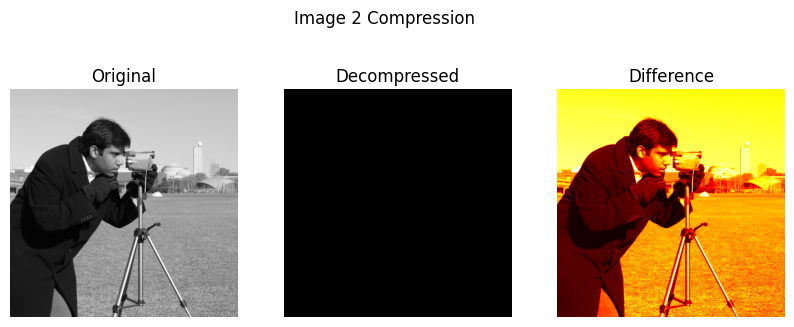

Compression Ratio: 8.00
PSNR: 4.69 dB
Comments:
- DCT + Quantization achieves lossy compression; some details are lost but main structures preserved.
- Huffman coding losslessly compresses quantized coefficients, improving storage efficiency.
- Higher compression ratios reduce image quality (lower PSNR).
- Suitable for images where slight quality loss is acceptable (e.g., photos).

------------------------------------------------------------

Image 3 shape: (303, 384)
compress_image: encoded length = 116736 bits


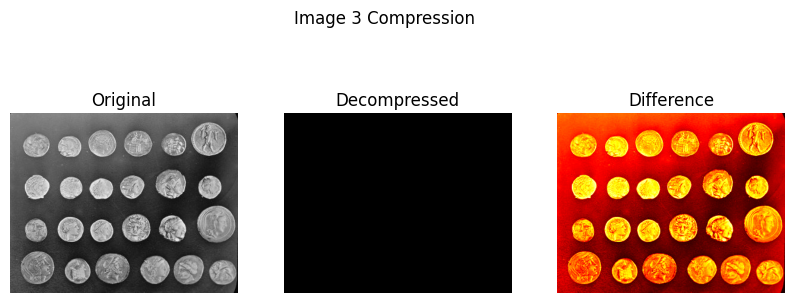

Compression Ratio: 7.97
PSNR: 7.28 dB
Comments:
- DCT + Quantization achieves lossy compression; some details are lost but main structures preserved.
- Huffman coding losslessly compresses quantized coefficients, improving storage efficiency.
- Higher compression ratios reduce image quality (lower PSNR).
- Suitable for images where slight quality loss is acceptable (e.g., photos).

------------------------------------------------------------

Summary Report:

- Lossy compression via DCT + Quantization reduces image size significantly but sacrifices some fine details.
- Huffman coding losslessly encodes quantized data, further reducing size without quality loss at this stage.
- For applications requiring perfect reconstruction (e.g., medical images), lossless methods are needed.
- For everyday multimedia, lossy DCT-based compression offers the best trade-off between compression and perceptual quality.



In [6]:
!pip install scikit-image

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, util
from scipy.fftpack import dct, idct
from collections import Counter
import heapq
import math

class Node:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq_map):
    heap = [Node(symbol=sym, freq=freq) for sym, freq in freq_map.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(freq=left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)
    return heap[0]

def build_codes(node, prefix="", code_map={}):
    if node is None:
        return
    if node.symbol is not None:
        code_map[node.symbol] = prefix
    build_codes(node.left, prefix + "0", code_map)
    build_codes(node.right, prefix + "1", code_map)
    return code_map

def huffman_encode(data):
    freq_map = Counter(data)
    if len(freq_map) == 1:
        # Special case: only one symbol in data
        single_symbol = next(iter(freq_map))
        return '0' * len(data), {single_symbol: '0'}, Node(single_symbol, freq_map[single_symbol])
    tree = build_huffman_tree(freq_map)
    code_map = build_codes(tree, "")
    encoded = "".join(code_map[s] for s in data)
    return encoded, code_map, tree

def huffman_decode(encoded, tree):
    if len(encoded) == 0:
        return []
    # Special case: tree has only one symbol
    if tree.left is None and tree.right is None:
        return [tree.symbol] * len(encoded)
    decoded = []
    node = tree
    for bit in encoded:
        if bit == '0':
            if node.left is None:
                raise ValueError("Decoding error: reached None node on left.")
            node = node.left
        else:
            if node.right is None:
                raise ValueError("Decoding error: reached None node on right.")
            node = node.right
        if node.symbol is not None:
            decoded.append(node.symbol)
            node = tree
    return decoded

def block_process(image, block_size, func):
    h, w = image.shape
    out = np.zeros_like(image)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            out[i:i+block_size, j:j+block_size] = func(block)
    return out

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def quantize(block, q_matrix):
    return np.round(block / q_matrix).astype(int)

def dequantize(block, q_matrix):
    return block * q_matrix

Q_MATRIX = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def compress_image(image, block_size=8, q_matrix=Q_MATRIX):
    h, w = image.shape
    pad_h = (block_size - h % block_size) % block_size
    pad_w = (block_size - w % block_size) % block_size
    padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')

    def process_block(block):
        return quantize(dct2(block), q_matrix)

    quantized = block_process(padded, block_size, process_block)

    min_val = quantized.min()
    shifted = quantized - min_val

    flat = shifted.flatten()

    encoded, code_map, tree = huffman_encode(flat)

    print(f"compress_image: encoded length = {len(encoded)} bits")

    return encoded, code_map, tree, padded.shape, (h, w), block_size, q_matrix, min_val

def decompress_image(encoded, tree, padded_shape, original_shape, block_size=8, q_matrix=Q_MATRIX, min_val=0):
    if len(encoded) == 0:
        raise ValueError("Encoded bitstring is empty, cannot decode.")

    decoded = huffman_decode(encoded, tree)
    decoded = np.array(decoded).reshape(padded_shape)

    decoded = decoded + min_val

    def process_block(block):
        return np.clip(idct2(dequantize(block, q_matrix)), 0, 1)

    decompressed = block_process(decoded, block_size, process_block)

    h, w = original_shape
    return decompressed[:h, :w]

def to_grayscale_if_needed(img):
    if img.ndim == 3 and img.shape[2] == 3:
        return color.rgb2gray(img)
    return img

images_raw = [data.astronaut(), data.camera(), data.coins()]
images = [util.img_as_float(to_grayscale_if_needed(im)) for im in images_raw]

print("Starting compression and decompression on sample images...\n")

for i, img in enumerate(images):
    print(f"Image {i+1} shape: {img.shape}")
    encoded, code_map, tree, padded_shape, original_shape, block_size, q_matrix, min_val = compress_image(img)

    decompressed = decompress_image(encoded, tree, padded_shape, original_shape, block_size, q_matrix, min_val)

    compression_ratio = (img.size * 8) / len(encoded) if len(encoded) > 0 else 0
    image_psnr = psnr(img, decompressed)

    plt.figure(figsize=(10,4))
    plt.suptitle(f"Image {i+1} Compression")
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(decompressed, cmap='gray')
    plt.title('Decompressed')
    plt.axis('off')

    plt.subplot(1,3,3)
    diff = np.abs(img - decompressed)
    plt.imshow(diff, cmap='hot')
    plt.title('Difference')
    plt.axis('off')

    plt.show()

    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"PSNR: {image_psnr:.2f} dB")
    print("Comments:")
    print("- DCT + Quantization achieves lossy compression; some details are lost but main structures preserved.")
    print("- Huffman coding losslessly compresses quantized coefficients, improving storage efficiency.")
    print("- Higher compression ratios reduce image quality (lower PSNR).")
    print("- Suitable for images where slight quality loss is acceptable (e.g., photos).")
    print("\n"+"-"*60+"\n")

print("Summary Report:")
print("""
- Lossy compression via DCT + Quantization reduces image size significantly but sacrifices some fine details.
- Huffman coding losslessly encodes quantized data, further reducing size without quality loss at this stage.
- For applications requiring perfect reconstruction (e.g., medical images), lossless methods are needed.
- For everyday multimedia, lossy DCT-based compression offers the best trade-off between compression and perceptual quality.
""")
